In [3]:
import numpy as np
from scipy.fftpack import fft, fftfreq

In [27]:
class Simulator:
    
    kb = 1.308064e-23 # Boltzmann constant
    
    def __init__(self):
        pass
    
    def configure_experiment(self, 
                             lambda_lazer = 650e-9,
                             temperature = 273.15,
                             theta = np.pi / 3,
                             n = 1.33,
                             eta = 0.958e-3):
        
        self.lambda_lazer = lambda_lazer
        self.temperature = temperature
        self.theta = theta
        self.n = n
        self.eta = eta
        
        #Evaluate coefficient
        self.coeff = 2*(Simulator.kb * self.temperature/(3 * np.pi * self.eta)) * (4 * np.pi * self.n / self.lambda_lazer)**2 * np.sin(self.theta / 2)**2
    
    
    def get_lorentz(self, diameter, freq):
        if diameter == 0:
            raise ValueError('zero passed as a diameter')
        
        G = self.coeff / diameter
        
        # QUESTION: Do we really need (1 / pi) here?
        return 1 / np.pi * G / ((2 * np.pi * freq)**2 + G**2)
    
    
    def run_simple_noise_simulation(self,
                                    particle_diameters=np.array([38e-9]),
                                    noise_level = 0.001,
                                    max_freq_value = 5514.0,
                                    num_frequencies = 2**15):
        
        # Generate @num_frequencies frequencies in the range [0, @max_freq_value]
        frequencies = np.linspace(0, max_freq_value, num_frequencies)
        
        # Obtain ideal lorentz
        ideal_lorentz = sum([self.get_lorentz(d, frequencies) for d in particle_diameters])
        
        # Obtain experimental lorentz affected by the noise of level @noise_level
        experimental_lorentz = np.array(list(map(lambda s: s + noise_level * np.random.uniform(-s, s), ideal_lorentz)))
        
        return (experimental_lorentz, frequencies)
        
        
          
    def run_simulation(self, 
                       particle_diameters = np.array([38e-9]),
                       noise_level = 0.0,
                       time_series_size = 2**16,
                       max_freq_value = 5514.0,
                       num_frequencies = 2**15):
        
        # x(t_i) = SUM_k^n [ sqrt(S(f_k)) * sin(2pi * f_k * t_i + phi_k)} ]
        
        # Generate @num_frequencies random frequencies uniformly distributed in the range [0, @max_freq_value]
        random_frequencies = np.random.uniform(0, max_freq_value, num_frequencies)
        
        # Generate @num_frequencies random initial phases (phi_k) uniformly distributed in the range [0, 2pi]
        initial_phases = np.random.uniform(0, 2 * np.pi, num_frequencies)
        
        # Create @time_series_size consecutive time values 0, 1, 2, ... , @time_series_size - 1
        time_series = np.linspace(0, time_series_size / 2**9, time_series_size)
        
        
        # Ideal lorentz S(f) = S[d1](f) + ... + S[dN](f)
        # Get an ideal amplitude SQRT(S(f)) for each random frequency (f_k) so as to obtain all SQRT[S(f_k)]
        ideal_lorentz = sum([self.get_lorentz(d, random_frequencies) for d in particle_diameters])
        ideal_amplitudes = np.sqrt(ideal_lorentz)
        
        
        # Obtain x(time_series)
        get_x_ti = lambda t: sum(ideal_amplitudes * np.sin(2 * np.pi * random_frequencies * t + initial_phases))
        x_t = np.array(list(map(get_x_ti, time_series[0:1000])))
        
        # Do normalization {x(t) - min(x(t))} so as to have positive (ala-experimental) values (refer to the article)
        min_x_t = min(x_t)
        x_t = x_t - min_x_t # FIXME: Due to peculiarity of calculations in CPU some values can be negative 
                            # (even though it has not happened yet)
                            # By the fact, we get squares of these numbers for the final result
        
        
        # Get experimental intesities: light intensity ~ (x_t)**2
        experimental_intensities = x_t**2
        
        
        # Fourier transform of experimental data
        experimental_lorentz = fft(experimental_intensities)
        freqs = fftfreq(len(experimental_intensities)) * 2**9
        
        return experimental_lorentz, freqs
        
                                                     
                                                     
                                                     
    
    

SyntaxError: non-default argument follows default argument (<ipython-input-27-9cf49d76aca5>, line 25)

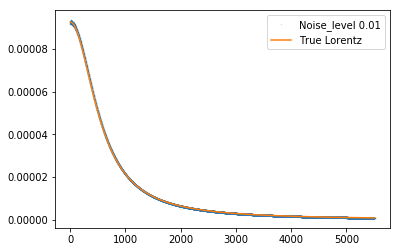

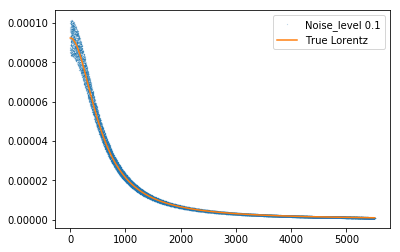

In [30]:
%matplotlib inline

import matplotlib.pyplot as plt

simulator = Simulator()
simulator.configure_experiment()

output1,freqs1 = simulator.run_simple_noise_simulation(noise_level = 0.01)
output2,freqs2 = simulator.run_simple_noise_simulation(noise_level = 0.1)

fig, ax = plt.subplots()
ax.plot(freqs1, output1,'o', markersize=0.1,label='Noise_level 0.01')
ax.plot(freqs1, simulator.get_lorentz(38e-9, freqs1), label='True Lorentz')

plt.legend()

fig1, ax1 = plt.subplots()
ax1.plot(freqs2, output2,'o', markersize=0.1, label='Noise_level 0.1')
ax1.plot(freqs2, simulator.get_lorentz(38e-9, freqs2), label='True Lorentz')

plt.legend()

/home/denis/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


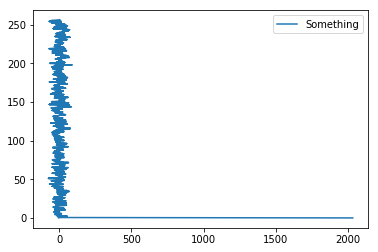

In [31]:
%matplotlib inline

simulator = Simulator()
simulator.configure_experiment()

freqs, output = simulator.run_simulation()

fig, ax = plt.subplots()
ax.plot(freqs, np.abs(output), label='Something')
plt.legend()